## 1 线性回归

In [2]:
import torch
from time import time

print(torch.__version__)

1.3.1


### 1.1 矢量计算表达式

In [3]:
a = torch.ones(10000)
b = torch.ones(10000)
# 标量计算
start = time()
c = torch.zeros(10000)
for i in range(10000):
    c[i] = a[i] + b[i]
print(time() - start)

# 矢量运算
start = time()
d = a + b
print(time() - start)

0.13732671737670898
7.295608520507812e-05


对于线性回归$\hat{\vec{y}} = X\vec{w} + b$，其中$b$本应是矢量，但这里写成标量即可。因为torch会自动触发广播机制。

In [5]:
a = torch.ones(3)
b = 1
print(a + b)

tensor([2., 2., 2.])


### 1.2 从零开始实现线性回归

In [6]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random
%matplotlib inline

#### 1.2.1 手动生成数据集
根据真实权重$\vec{w} = [2, -3.4]^\top$，真实偏差$b = 4.2$，以及一个随机噪声项$\epsilon$生成1000个样本标签$y$：
$$
\vec{y} = X \vec{w} + b + \epsilon,
$$
其中$\epsilon$服从$\mathcal{N}(\mu=0, \sigma^2=0.01)$。

In [7]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

观察$w_2$和label之间的关系。在此之前先对matplotlib进行一些设置。

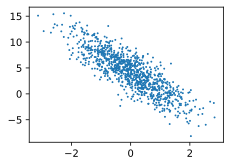

In [10]:
# --------utils--------
def use_svg_display():
    display.set_matplotlib_formats('svg')

# --------utils--------
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

# 绘制散点图观察关系
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

#### 1.2.2 读取mini-batch数据

In [19]:
def get_mini_batch_data(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # 最后一个batch可能不足batch_size个样本
        selected_indices = torch.LongTensor(indices[i: min(i+batch_size, num_examples)])
        yield features.index_select(0, selected_indices), labels.index_select(0, selected_indices)

观察第一个min-batch中的样本：

In [21]:
for X, y in get_mini_batch_data(10, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.4708, -1.4869],
        [ 1.1822,  0.9472],
        [ 2.2388,  0.4173],
        [ 0.2843,  0.1257],
        [ 0.0837, -0.8712],
        [ 0.2578, -0.9430],
        [ 0.3610, -0.1174],
        [-0.5416,  1.2075],
        [ 1.9548, -0.8101],
        [-1.3911, -1.4102]]) 
 tensor([12.1988,  3.3481,  7.2580,  4.3364,  7.3387,  7.9165,  5.3267, -0.9829,
        10.8679,  6.1978])


#### 1.2.3 初始化模型参数

In [23]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32, requires_grad=True)
b = torch.zeros(1, dtype=torch.float32, requires_grad=True)

#### 1.2.4 定义线性回归模型

In [25]:
def linreg(X, w, b):
    # torch matrix multiply and broadcast
    return torch.mm(X, w) + b

#### 1.2.5 定义均方误差损失函数

In [26]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

#### 1.2.6 Mini-batch梯度下降算法
设$\vec{\theta} = (\vec{w}, b)$，则MGD的迭代步骤为：
$$
\vec{\theta} \leftarrow \vec{\theta} - \frac{\eta}{|\mathcal{B}|} 
\sum_{i \in \mathcal{B}} \nabla_{\theta} l^{(i)} (\theta),
$$
具体地，
$$
k=1, 2: w_k \leftarrow w_k - \frac{\eta}{|\mathcal{B}|} 
\sum_{i \in \mathcal{B}} x_k^{(i)} \Big( [\vec{x}^{(i)}]^\top \vec{w} + b - y^{(i)} \Big),
$$
$$
b \leftarrow b - \frac{\eta}{|\mathcal{B}|} 
\sum_{i \in \mathcal{B}} \Big( [\vec{x}^{(i)}]^\top \vec{w} + b - y^{(i)} \Big).
$$
当然，梯度部分$\nabla_{\theta} l^{(i)} (\theta)$全权交给torch即可。只需要调用``.grad``即可获得梯度。

In [35]:
def mgd(params, lr, batch_size):
    """
    Mini-batch Gradient Desecnt.
    """
    for param in params:
        param.data -= lr * param.grad / batch_size

#### 1.2.7 训练模型
注意均方误差函数返回的是一个矢量，大小为$\mathbb{R}^{|\mathcal{B}|}$。一种简单的方式是对均方误差函数返回的矢量求和（即$\vec{1}^\top \vec{l}$），这样既转换成了标量，也不违背MGD的迭代过程。

In [36]:
lr = 0.03
num_epochs = 3
batch_size = 10

for epoch in range(num_epochs):
    # 一个epoch中，每个样本会被使用一次
    for X, y in get_mini_batch_data(batch_size=batch_size, features=features, labels=labels):
        # 求和变标量
        l = squared_loss(linreg(X, w, b), y).sum()
        # 计算梯度并根据MGD更新参数
        l.backward()
        mgd([w, b], lr, batch_size)
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = squared_loss(linreg(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.029724
epoch 2, loss 0.000127
epoch 3, loss 0.000050


对比训练结果和参数真值：

In [37]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9993],
        [-3.3993]], requires_grad=True)
4.2 
 tensor([4.2000], requires_grad=True)


### 1.3 线性回归的PyTorch实现